In [1]:
import pylhe
import itertools
import math as mt
import mplhep as hep
hep.style.use("CMS")
import matplotlib.pyplot as plt
import numpy as np

In [136]:
folders = ["78p387", "79p387", "80p387", "81p387", "82p387"]
masses = [float(i.replace("p", ".")) for i in folders]

nominal = "80p387"

# Read "DATA" aka MC events geenrated with MW=80p387

In [137]:
lhe_file = "Wboson_NLO/Events/80p387/events.lhe"
events = pylhe.read_lhe_with_attributes(lhe_file)
nevents = pylhe.read_num_events(lhe_file)
print(f"Number of events: {nevents}")

Number of events: 50000


In [138]:
# Let's build some functions to handle 4 momenta
# Expected format of the input four vec is 
# [px, py, pz, E]

def compute_mass(four_vec: list)-> float:
    return mt.sqrt(four_vec[-1]**2 - (sum(i**2 for i in four_vec[:-1])))

def compute_pt(four_vec: list)-> float:
    return mt.sqrt(four_vec[0]**2 + four_vec[1]**2)

def compute_eta(four_vec: list)-> float:
    return 0.5*mt.log((four_vec[-1] + four_vec[-2])/(four_vec[-1] - four_vec[-2]))

In [139]:
events = pylhe.read_lhe_with_attributes(lhe_file)

pt_mu_data = []
cross_section_weight = []

for event in events:
    # select only final state particles
    part = [i for i in event.particles if i.status == 1.0]
    # muon or antimuon
    p__ = [i for i in part if abs(i.id) == 13][0] # we only expect one muon

    # load the event weight 
    cross_section_weight.append(event.eventinfo.weight)
    
    # build ttbar 4 momenta
    mu_fourm = [p__.px, p__.py, p__.pz, p__.e]

    pt_mu_data.append(compute_pt(mu_fourm))

cross_section_weight = [i / nevents for i in cross_section_weight]

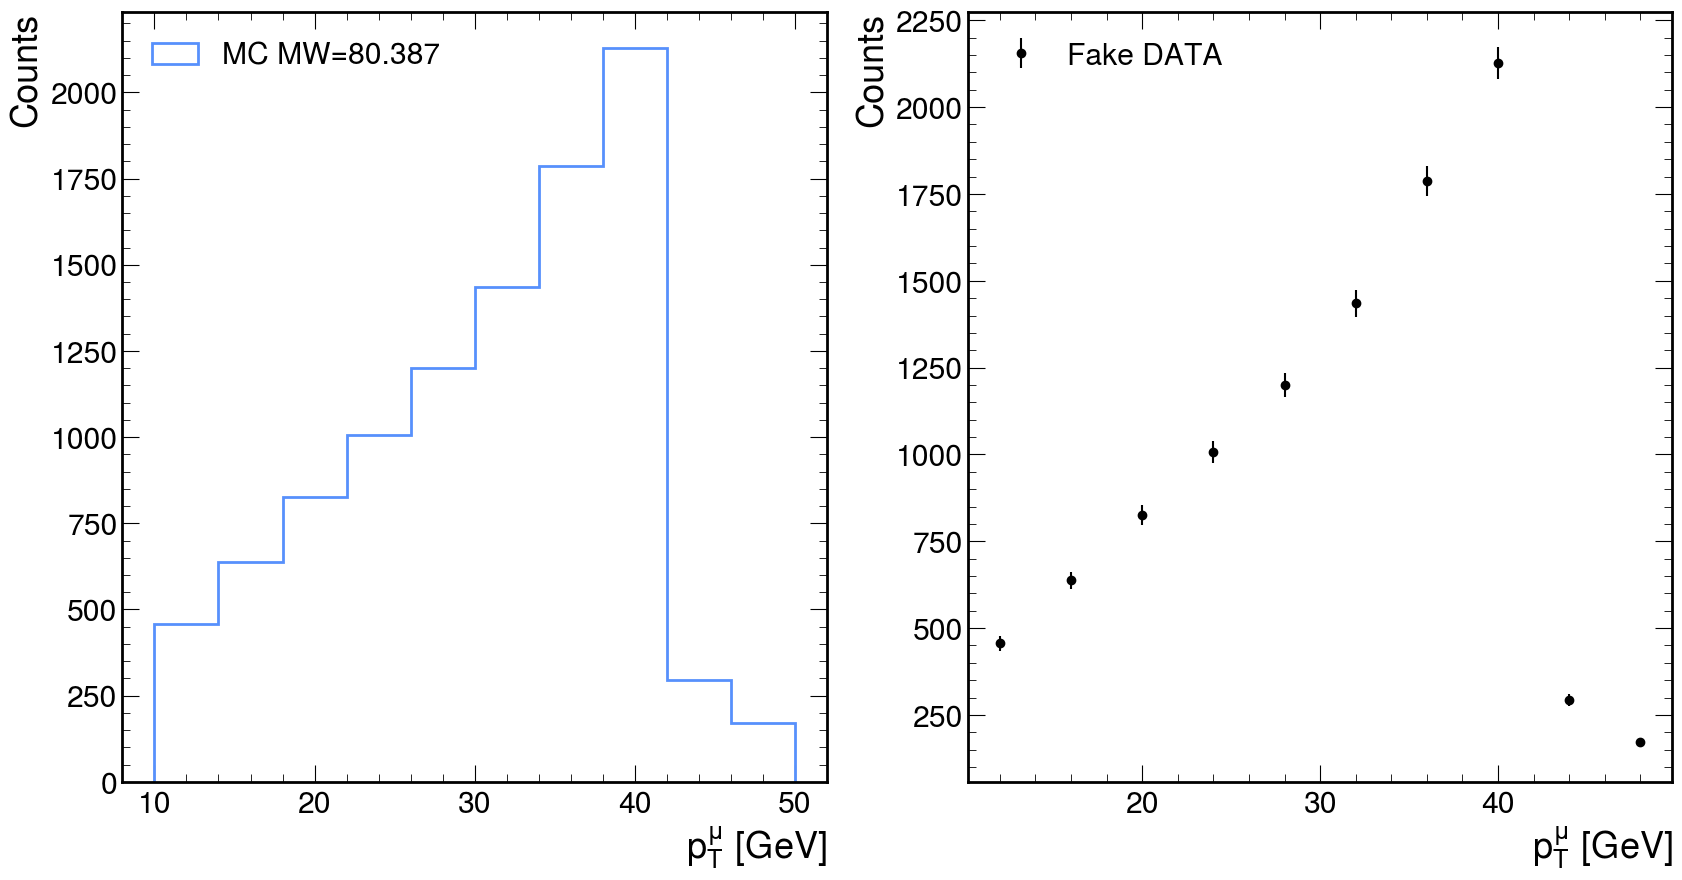

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# to plot histograms
nbins = 10
r__ = [10, 50]

ndata, bins, p = ax[0].hist(pt_mu_data, weights=cross_section_weight, bins=nbins, label="MC MW=80.387", histtype=u'step', linewidth=2, range=r__)


data, _  = np.histogram(pt_mu_data, nbins,  weights=cross_section_weight, range=r__)
err = np.sqrt(data)
mid = 0.5*(bins[1:] + bins[:-1])
ax[1].errorbar(mid, data, yerr=err, fmt='black', ecolor='black', marker='o', label="Fake DATA", ls='none')

ax[0].legend(loc="best")
ax[0].set_xlabel(r"$p_{T}^{\mu}$ [GeV]")
ax[0].set_ylabel('Counts')
#ax[0].set_yscale("log")

ax[1].legend(loc="best")
ax[1].set_xlabel(r"$p_{T}^{\mu}$ [GeV]")
ax[1].set_ylabel('Counts')
#ax[1].set_yscale("log")
    
plt.show()
#fig.savefig("tt_mass_differential.png")

In [141]:
w_mass = dict.fromkeys(masses)

for folder, mass in zip(folders, masses):

    # skip data 
    # if folder == nominal: continue

    events = pylhe.read_lhe_with_attributes(f"Wboson_NLO/Events/{folder}/events.lhe")
    nevents = pylhe.read_num_events(lhe_file)

    w_mass[mass] = {"values": [], "weight": []}
    
    for event in events:
        # select only final state particles
        part = [i for i in event.particles if i.status == 1.0]
        # muon or antimuon
        p__ = [i for i in part if abs(i.id) == 13][0] # we only expect one muon
    
        # load the event weight 
        w_mass[mass]["weight"].append(event.eventinfo.weight)
        
        # build ttbar 4 momenta
        mu_fourm = [p__.px, p__.py, p__.pz, p__.e]
    
        w_mass[mass]["values"].append(compute_pt(mu_fourm))
    
    
    w_mass[mass]["weight"] = [i / nevents for i in w_mass[mass]["weight"]]

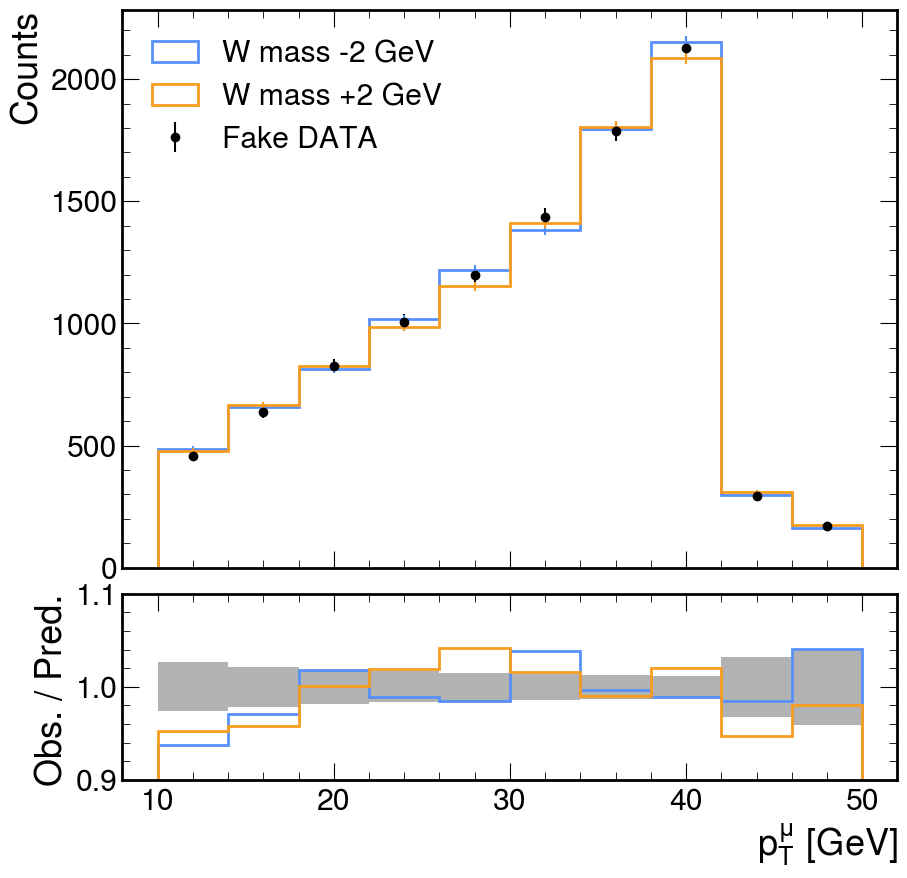

In [142]:
ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}

shaded_style = {
    'facecolor': (0,0,0,0.3),
    'linewidth': 0
}

fig, (ax, rax) = plt.subplots(2, 1, sharex=True, **ratio_fig_style)
fig.subplots_adjust(hspace=.07)  # this controls the margin between the two axes

# to plot histograms
nbins = 10
r__ = [10, 50]

data, _  = np.histogram(pt_mu_data, nbins,  weights=cross_section_weight, range=r__)
err = np.sqrt(data)
mid = 0.5*(bins[1:] + bins[:-1])
ax.errorbar(mid, data, yerr=err, fmt='black', ecolor='black', marker='o', label="Fake DATA", ls='none')

for mass, lab in zip([78.387, 82.387], ['-2', '+2']):
    label = f"W mass {lab} GeV"
    
    n, bins, p = ax.hist(w_mass[mass]["values"], weights=w_mass[mass]["weight"], bins=nbins, label=label, histtype=u'step', linewidth=2, range=r__)
    rax.hist(bins[:-1], weights=data/n, bins=len(n), label=label, histtype=u'step', linewidth=2, range=r__)
    
    # to compute statistical error we use sumw2 for each bin. We make another histogram
    sumw2, _  = np.histogram(w_mass[mass]["values"], nbins,  weights=[i**2 for i in w_mass[mass]["weight"]], range=r__)
    err = np.sqrt(sumw2)
    mid = 0.5*(bins[1:] + bins[:-1])
    
    ax.errorbar(mid, n, yerr=err, fmt='none', ecolor=p[0].get_edgecolor())

ax.legend(loc="best")
ax.set_ylabel('Counts')

err__ = np.append(err, err[-1])
data__ = np.append(data, data[-1])

rax.fill_between(x=bins, y1=1 - err__/data__, y2=1 + err__/data__, step='post', **shaded_style)
#sumw_total = sumw_total[:-1]  # Take away that copy of the last bin
#rax.errorbar(x=bin_centers, y=observed_pdf/sumw_total, yerr=np.sqrt(observed_pdf)/sumw_total, **errorbar_style)



rax.set_ylim(0.9, 1.1)
rax.set_ylabel('Obs. / Pred.')
# setting the x label on the stack pad clashes with the ratio axes frame
# we have to autoscale in the ratio axis after drawing all items
rax.autoscale(axis='x', tight=True)
rax.set_xlabel(r"$p_{T}^{\mu}$ [GeV]")
plt.show()
fig.savefig("Wmass.png")

# Compute chi2 as a function of mass

/var/folders/q4/tb4566c55x9723l0cgvrj9dc0000gp/T/ipykernel_60954/1399062302.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


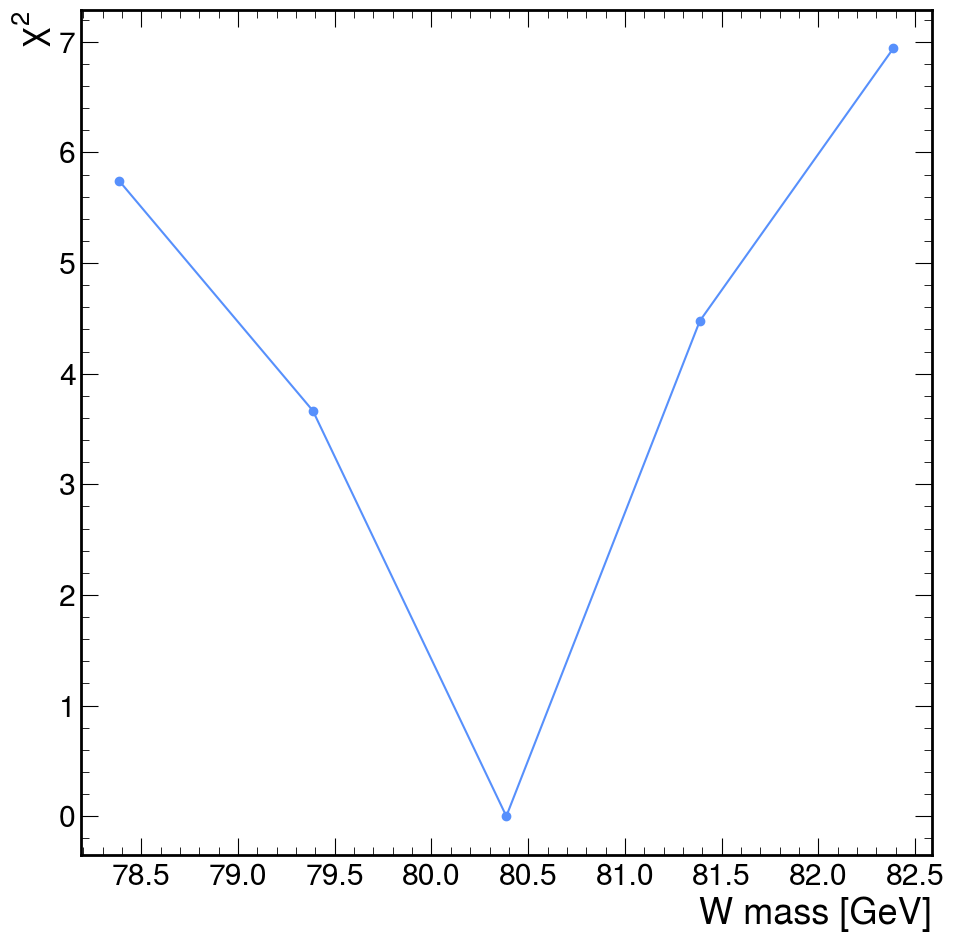

In [143]:
bin_counts = dict.fromkeys(masses)

nbins = 10
r__ = [10, 50]

for mass in masses:
    mbins, _  = np.histogram(w_mass[mass]["values"], nbins,  weights=w_mass[mass]["weight"], range=r__)
    bin_counts[mass] = mbins

chi = [sum(np.pow(data - bin_counts[mass] , 2)/bin_counts[mass] ) for mass in masses]


fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(masses, chi, marker='o')

ax.legend(loc="best")
ax.set_xlabel(r"W mass [GeV]")
ax.set_ylabel(r'$\chi^2$')    

fig.tight_layout()
fig.savefig("Wmass_sensitivity.png")